In [1]:
import pandas as pd  
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

In [2]:
import pyspark
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder\
       .master("local[*]")\
       .appName("Spark_App")\
       .getOrCreate()

In [4]:
titanic = spark.read.csv('titanic.csv', header='true', inferSchema='true', sep=',')
titanic.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
|          6|       0|     3|    Moran, Mr. James|  male|null|    0|    0|      

In [5]:
titanic.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [6]:
columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
titanic = titanic.drop(*columns_to_drop)

In [7]:
titanic.show()

+--------+------+------+----+-----+-----+-------+--------+
|Survived|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|
+--------+------+------+----+-----+-----+-------+--------+
|       0|     3|  male|22.0|    1|    0|   7.25|       S|
|       1|     1|female|38.0|    1|    0|71.2833|       C|
|       1|     3|female|26.0|    0|    0|  7.925|       S|
|       1|     1|female|35.0|    1|    0|   53.1|       S|
|       0|     3|  male|35.0|    0|    0|   8.05|       S|
|       0|     3|  male|null|    0|    0| 8.4583|       Q|
|       0|     1|  male|54.0|    0|    0|51.8625|       S|
|       0|     3|  male| 2.0|    3|    1| 21.075|       S|
|       1|     3|female|27.0|    0|    2|11.1333|       S|
|       1|     2|female|14.0|    1|    0|30.0708|       C|
|       1|     3|female| 4.0|    1|    1|   16.7|       S|
|       1|     1|female|58.0|    0|    0|  26.55|       S|
|       0|     3|  male|20.0|    0|    0|   8.05|       S|
|       0|     3|  male|39.0|    1|    5| 31.275|       

In [8]:
from pyspark.sql import functions as Fun

EmbarkedMean = titanic.groupBy("Embarked")\
    .agg(Fun.mean("Survived").alias("EmbarkedMean")) \
    .sort("EmbarkedMean", ascending=False)

In [9]:
EmbarkedMean.show()

+--------+-------------------+
|Embarked|       EmbarkedMean|
+--------+-------------------+
|    null|                1.0|
|       C| 0.5535714285714286|
|       Q|0.38961038961038963|
|       S|0.33695652173913043|
+--------+-------------------+



In [10]:
titanic = titanic.join(EmbarkedMean, on=['Embarked'], how='inner')

In [11]:
titanic.show()

+--------+--------+------+------+----+-----+-----+-------+-------------------+
|Embarked|Survived|Pclass|   Sex| Age|SibSp|Parch|   Fare|       EmbarkedMean|
+--------+--------+------+------+----+-----+-----+-------+-------------------+
|       S|       0|     3|  male|22.0|    1|    0|   7.25|0.33695652173913043|
|       C|       1|     1|female|38.0|    1|    0|71.2833| 0.5535714285714286|
|       S|       1|     3|female|26.0|    0|    0|  7.925|0.33695652173913043|
|       S|       1|     1|female|35.0|    1|    0|   53.1|0.33695652173913043|
|       S|       0|     3|  male|35.0|    0|    0|   8.05|0.33695652173913043|
|       Q|       0|     3|  male|null|    0|    0| 8.4583|0.38961038961038963|
|       S|       0|     1|  male|54.0|    0|    0|51.8625|0.33695652173913043|
|       S|       0|     3|  male| 2.0|    3|    1| 21.075|0.33695652173913043|
|       S|       1|     3|female|27.0|    0|    2|11.1333|0.33695652173913043|
|       C|       1|     2|female|14.0|    1|    0|30

In [12]:
titanic = titanic.drop('Embarked')

In [13]:
AgeMean = titanic.groupBy().mean("Age").collect()[0][0]

In [14]:
AgeMean = int(AgeMean)

In [15]:
titanic = titanic.na.fill(AgeMean, "Age")

In [16]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

stringIndexer = StringIndexer()\
  .setInputCol("Sex")\
  .setOutputCol("SexIndex")

model = stringIndexer.fit(titanic)
indexed = model.transform(titanic)

encoder = OneHotEncoder(inputCol="SexIndex", outputCol="SexEncoding")
encoded = encoder.transform(indexed)
encoded = encoded.drop('Sex')
encoded = encoded.drop('SexIndex')
titanic = encoded
titanic.show()

+--------+------+----+-----+-----+-------+-------------------+-------------+
|Survived|Pclass| Age|SibSp|Parch|   Fare|       EmbarkedMean|  SexEncoding|
+--------+------+----+-----+-----+-------+-------------------+-------------+
|       0|     3|22.0|    1|    0|   7.25|0.33695652173913043|(1,[0],[1.0])|
|       1|     1|38.0|    1|    0|71.2833| 0.5535714285714286|    (1,[],[])|
|       1|     3|26.0|    0|    0|  7.925|0.33695652173913043|    (1,[],[])|
|       1|     1|35.0|    1|    0|   53.1|0.33695652173913043|    (1,[],[])|
|       0|     3|35.0|    0|    0|   8.05|0.33695652173913043|(1,[0],[1.0])|
|       0|     3|29.0|    0|    0| 8.4583|0.38961038961038963|(1,[0],[1.0])|
|       0|     1|54.0|    0|    0|51.8625|0.33695652173913043|(1,[0],[1.0])|
|       0|     3| 2.0|    3|    1| 21.075|0.33695652173913043|(1,[0],[1.0])|
|       1|     3|27.0|    0|    2|11.1333|0.33695652173913043|    (1,[],[])|
|       1|     2|14.0|    1|    0|30.0708| 0.5535714285714286|    (1,[],[])|

In [17]:
from pyspark.sql.functions import col, log

titanic = titanic.withColumn("AgeLog", log(col("Age")))
titanic = titanic.withColumn("FareLog", log(col("Fare")))
titanic = titanic.drop('Age')
titanic = titanic.drop('Fare')
titanic.show()

+--------+------+-----+-----+-------------------+-------------+------------------+------------------+
|Survived|Pclass|SibSp|Parch|       EmbarkedMean|  SexEncoding|            AgeLog|           FareLog|
+--------+------+-----+-----+-------------------+-------------+------------------+------------------+
|       0|     3|    1|    0|0.33695652173913043|(1,[0],[1.0])| 3.091042453358316|1.9810014688665833|
|       1|     1|    1|    0| 0.5535714285714286|    (1,[],[])|3.6375861597263857|  4.26666207838721|
|       1|     3|    0|    0|0.33695652173913043|    (1,[],[])| 3.258096538021482|2.0700223197633445|
|       1|     1|    1|    0|0.33695652173913043|    (1,[],[])|3.5553480614894135|3.9721769282478934|
|       0|     3|    0|    0|0.33695652173913043|(1,[0],[1.0])|3.5553480614894135|2.0856720914304723|
|       0|     3|    0|    0|0.38961038961038963|(1,[0],[1.0])| 3.367295829986474| 2.135148207799377|
|       0|     1|    0|    0|0.33695652173913043|(1,[0],[1.0])|3.9889840465642745|

In [18]:
titanic = titanic.dropna()

In [19]:
titanic = VectorAssembler(inputCols=['Pclass', 'AgeLog', 'SibSp', 'Parch', 'FareLog', 'EmbarkedMean',  'SexEncoding'], \
        outputCol='features')\
        .transform(titanic)

titanic = titanic.withColumnRenamed('Survived', 'label')

titanic = titanic.select("features", "label")

In [20]:
train, test = titanic.randomSplit([0.7, 0.3], seed = 2020)
titanic.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[3.0,3.0910424533...|    0|
|[1.0,3.6375861597...|    1|
|[3.0,3.2580965380...|    1|
|[1.0,3.5553480614...|    1|
|[3.0,3.5553480614...|    0|
|[3.0,3.3672958299...|    0|
|[1.0,3.9889840465...|    0|
|[3.0,0.6931471805...|    0|
|[3.0,3.2958368660...|    1|
|[2.0,2.6390573296...|    1|
|[3.0,1.3862943611...|    1|
|[1.0,4.0604430105...|    1|
|[3.0,2.9957322735...|    0|
|[3.0,3.6635616461...|    0|
|[3.0,2.6390573296...|    0|
|[2.0,4.0073331852...|    1|
|[3.0,0.6931471805...|    0|
|[2.0,3.3672958299...|    1|
|[3.0,3.4339872044...|    0|
|[3.0,3.3672958299...|    1|
+--------------------+-----+
only showing top 20 rows



In [21]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='features', labelCol='label')

In [22]:
model = lr.fit(train)

In [23]:
print("Coefficients: " + str(model.coefficients))
print("Intercept: " + str(model.intercept))

Coefficients: [-1.0954819671405007,-1.0651336317715174,-0.5588420068938585,-0.23957032345460166,0.03844884615523674,2.019081749217657,-2.7571391140722175]
Intercept: 6.620199453535127


In [24]:
trainingSummary = model.summary

In [25]:
trainingSummary.roc.show()
print("Train Area Under ROC:" + str(trainingSummary.areaUnderROC))

+--------------------+-------------------+
|                 FPR|                TPR|
+--------------------+-------------------+
|                 0.0|                0.0|
|                 0.0|0.02145922746781116|
|                 0.0|0.04291845493562232|
|                 0.0|0.06437768240343347|
|                 0.0|0.08583690987124463|
|                 0.0| 0.1072961373390558|
|                 0.0|0.12875536480686695|
|                 0.0|0.15021459227467812|
|0.002638522427440633|0.16738197424892703|
|0.002638522427440633| 0.1888412017167382|
|0.002638522427440633|0.21030042918454936|
|0.002638522427440633| 0.2317596566523605|
|0.002638522427440633| 0.2532188841201717|
|0.002638522427440633|0.27467811158798283|
|0.002638522427440633|  0.296137339055794|
|0.005277044854881266| 0.3133047210300429|
|  0.0079155672823219|0.33476394849785407|
|  0.0079155672823219| 0.3605150214592275|
|  0.0079155672823219|0.38197424892703863|
|  0.0079155672823219| 0.4034334763948498|
+----------

In [26]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="label")
predict_train=model.transform(train)
predict_test=model.transform(test)

print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test)))

The area under ROC for train set is 0.856410024120398
The area under ROC for test set is 0.8751511852926951


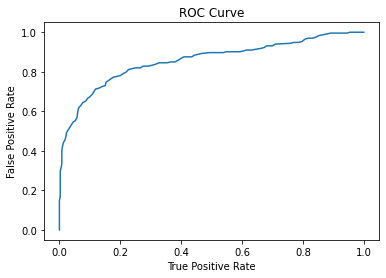

In [27]:
roc = trainingSummary.roc.toPandas()

plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

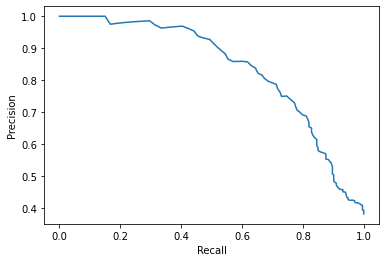

In [28]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [29]:
predictions = model.transform(test)

predictions.select("rawPrediction", "prediction", "probability", "label", "features").show()

+--------------------+----------+--------------------+-----+--------------------+
|       rawPrediction|prediction|         probability|label|            features|
+--------------------+----------+--------------------+-----+--------------------+
|[-4.6218316337304...|       1.0|[0.00973898522552...|    0|[1.0,0.6931471805...|
|[-0.0399331148068...|       1.0|[0.49001804774274...|    1|[1.0,2.3978952727...|
|[-3.1535644878167...|       1.0|[0.04095105697196...|    1|[1.0,2.7725887222...|
|[-3.6057811937387...|       1.0|[0.02644772974709...|    1|[1.0,2.7725887222...|
|[-0.5694284326549...|       1.0|[0.36136872149061...|    1|[1.0,2.8332133440...|
|[-2.7839180802806...|       1.0|[0.05819942462169...|    1|[1.0,2.8332133440...|
|[-3.1996113811799...|       1.0|[0.03918034982976...|    1|[1.0,2.9444389791...|
|[1.62972362221771...|       0.0|[0.83613177427369...|    0|[1.0,2.9444389791...|
|[-2.0169269664764...|       1.0|[0.11743712316249...|    1|[1.0,3.0445224377...|
|[-0.78169316770

In [30]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = ParamGridBuilder()\
    .addGrid(lr.aggregationDepth,[2,5,10])\
    .addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0])\
    .addGrid(lr.fitIntercept,[False, True])\
    .addGrid(lr.maxIter,[10, 100, 1000])\
    .addGrid(lr.regParam,[0.01, 0.5, 2.0]) \
    .build()

In [31]:
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations
cvModel = cv.fit(train)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing
predict_train=cvModel.transform(train)
predict_test=cvModel.transform(test)
print("The area under ROC for train set after CV  is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set after CV  is {}".format(evaluator.evaluate(predict_test)))

The area under ROC for train set after CV  is 0.8550964249719725
The area under ROC for test set after CV  is 0.87844702467344


In [32]:
bestModel = cvModel.bestModel
finalPredictions = bestModel.transform(test)
print("Get default metric for the binary classification evaluator is "+evaluator.getMetricName())
print("The area under ROC for test set after CV  is {}".format(evaluator.evaluate(finalPredictions)))

Get default metric for the binary classification evaluator is areaUnderROC
The area under ROC for test set after CV  is 0.87844702467344


In [33]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8751511852926951


In [34]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label')
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select("rawPrediction", "prediction", "probability", "label", "features").show()

+-------------+----------+--------------------+-----+--------------------+
|rawPrediction|prediction|         probability|label|            features|
+-------------+----------+--------------------+-----+--------------------+
|   [1.0,59.0]|       1.0|[0.01666666666666...|    0|[1.0,0.6931471805...|
|  [33.0,24.0]|       0.0|[0.57894736842105...|    1|[1.0,2.3978952727...|
|   [1.0,59.0]|       1.0|[0.01666666666666...|    1|[1.0,2.7725887222...|
|   [1.0,59.0]|       1.0|[0.01666666666666...|    1|[1.0,2.7725887222...|
|  [33.0,24.0]|       0.0|[0.57894736842105...|    1|[1.0,2.8332133440...|
|   [1.0,59.0]|       1.0|[0.01666666666666...|    1|[1.0,2.8332133440...|
|   [3.0,42.0]|       1.0|[0.06666666666666...|    1|[1.0,2.9444389791...|
|  [33.0,24.0]|       0.0|[0.57894736842105...|    0|[1.0,2.9444389791...|
|   [1.0,59.0]|       1.0|[0.01666666666666...|    1|[1.0,3.0445224377...|
|  [33.0,24.0]|       0.0|[0.57894736842105...|    0|[1.0,3.0910424533...|
|   [1.0,59.0]|       1.0

In [35]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.5206821480406387


In [36]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select("rawPrediction", "prediction", "probability", "label", "features").show()

+--------------------+----------+--------------------+-----+--------------------+
|       rawPrediction|prediction|         probability|label|            features|
+--------------------+----------+--------------------+-----+--------------------+
|[1.77878733086715...|       1.0|[0.08893936654335...|    0|[1.0,0.6931471805...|
|[6.91728203025976...|       1.0|[0.34586410151298...|    1|[1.0,2.3978952727...|
|[1.33536776803490...|       1.0|[0.06676838840174...|    1|[1.0,2.7725887222...|
|[1.27536776803490...|       1.0|[0.06376838840174...|    1|[1.0,2.7725887222...|
|[10.8681492256777...|       0.0|[0.54340746128388...|    1|[1.0,2.8332133440...|
|[1.54779047141190...|       1.0|[0.07738952357059...|    1|[1.0,2.8332133440...|
|[2.15372205123275...|       1.0|[0.10768610256163...|    1|[1.0,2.9444389791...|
|[8.12786022821906...|       1.0|[0.40639301141095...|    0|[1.0,2.9444389791...|
|[1.76217682566529...|       1.0|[0.08810884128326...|    1|[1.0,3.0445224377...|
|[12.54693362668

In [37]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8642356071601356


In [38]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select("rawPrediction", "prediction", "probability", "label", "features").show()

+--------------------+----------+--------------------+-----+--------------------+
|       rawPrediction|prediction|         probability|label|            features|
+--------------------+----------+--------------------+-----+--------------------+
|[-1.3298653575853...|       1.0|[0.06539178903126...|    0|[1.0,0.6931471805...|
|[-0.5521541648040...|       1.0|[0.24893351389437...|    1|[1.0,2.3978952727...|
|[-1.3298653575853...|       1.0|[0.06539178903126...|    1|[1.0,2.7725887222...|
|[-1.3298653575853...|       1.0|[0.06539178903126...|    1|[1.0,2.7725887222...|
|[0.24394452332561...|       0.0|[0.61960901975090...|    1|[1.0,2.8332133440...|
|[-1.3298653575853...|       1.0|[0.06539178903126...|    1|[1.0,2.8332133440...|
|[-0.1588522770190...|       1.0|[0.42123526725635...|    1|[1.0,2.9444389791...|
|[0.22004119969919...|       0.0|[0.60827866469854...|    0|[1.0,2.9444389791...|
|[-1.3298653575853...|       1.0|[0.06539178903126...|    1|[1.0,3.0445224377...|
|[0.216879468314

In [39]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.842918480890179


In [40]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8660498306724722
